In [24]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import influence_plot, plot_partregress
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA





In [2]:
df = pd.read_csv("clean_playoff_passing.csv")


In [3]:
# poisson regression lasso selection
# -----
predictors = [
    "IAY/PA",
    "CAY/PA",
    "YAC/Cmp",
    "Int",
    "Prss%",
    "PktTime",
    "Drop%",
    "Bad%"
]

response = "playoff_games_won"

combined = df[predictors + [response]].dropna()
X = combined[predictors].values
y = combined[response].values

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept column
X_scaled = sm.add_constant(X_scaled)

# Variable names including intercept
var_names = ['Intercept'] + predictors

# -------------------------
# 2. Poisson Lasso variable selection
# -------------------------
alphas = [0.005, 0.01, 0.02, 0.05, 0.1]
print("Poisson Lasso Variable Selection:")

for a in alphas:
    poisson_lasso = sm.GLM(y, X_scaled, family=sm.families.Poisson()).fit_regularized(
        method='elastic_net',
        alpha=a,
        L1_wt=1.0,
        maxiter=50000
    )
    coefs = poisson_lasso.params
    selected = [name for name, coef in zip(var_names, coefs) if coef != 0 and name != 'Intercept']
    print(f"alpha={a}: selected variables = {selected}")
# -------------------------
# 3. Fit final Poisson GLM using selected variables
# -------------------------
alpha_final = 0.01
poisson_lasso_final = sm.GLM(y, X_scaled, family=sm.families.Poisson()).fit_regularized(
    method='elastic_net',
    alpha=alpha_final,
    L1_wt=1.0,
    maxiter=50000
)

coefs_final = poisson_lasso_final.params
selected_vars = [name for name, coef in zip(var_names, coefs_final) if coef != 0 and name != 'Intercept']
print(f"\nFinal selected variables (alpha={alpha_final}): {selected_vars}")


Poisson Lasso Variable Selection:
alpha=0.005: selected variables = ['IAY/PA', 'CAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']
alpha=0.01: selected variables = ['IAY/PA', 'CAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']
alpha=0.02: selected variables = ['IAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']
alpha=0.05: selected variables = ['IAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']
alpha=0.1: selected variables = ['IAY/PA', 'YAC/Cmp', 'Int', 'Bad%']

Final selected variables (alpha=0.01): ['IAY/PA', 'CAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']


                 Generalized Linear Model Regression Results                  
Dep. Variable:      playoff_games_won   No. Observations:                   96
Model:                            GLM   Df Residuals:                       90
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -116.14
Date:                Mon, 01 Dec 2025   Deviance:                       110.04
Time:                        15:16:12   Pearson chi2:                     104.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1830
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2367      0.735      0.322      0.7

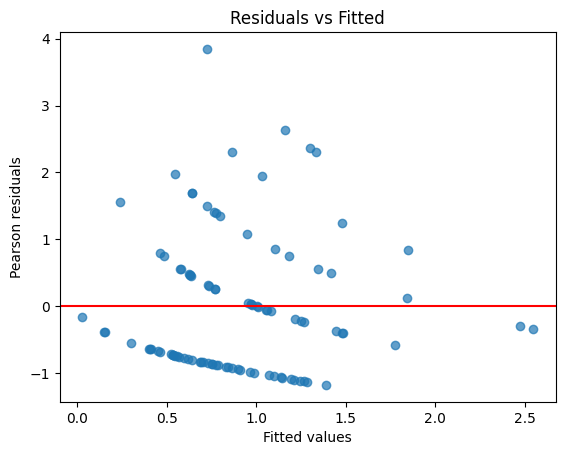

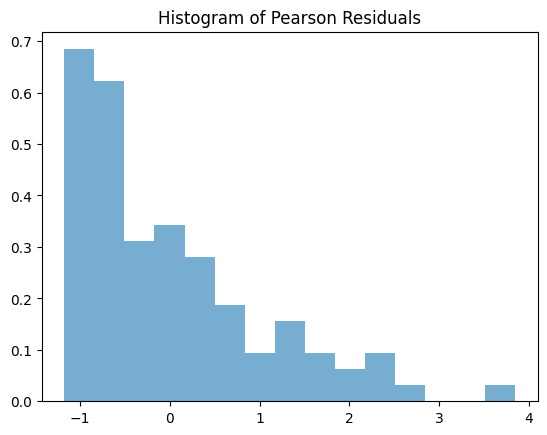

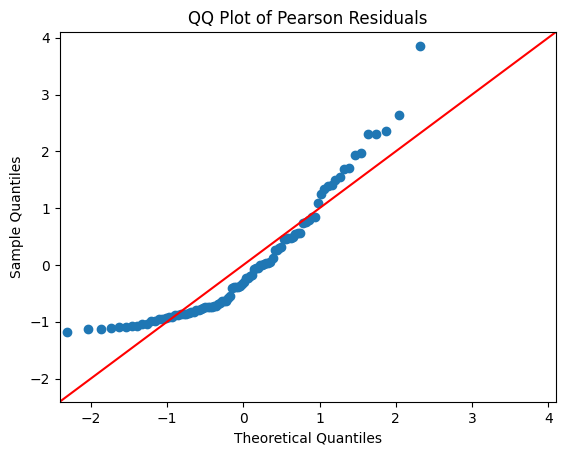


Overdispersion ratio: 1.15

Variance Inflation Factors for selected variables:
  Variable       VIF
0   IAY_PA  1.220788
1  YAC_Cmp  1.244601
2      Int  1.040519
3  DropPct  1.017297
4   BadPct  1.057405


In [4]:

# Rename columns to valid Python identifiers
combined = combined.rename(columns={
    "IAY/PA": "IAY_PA",
    "CAY/PA": "CAY_PA",
    "YAC/Cmp": "YAC_Cmp",
    "Prss%": "PrssPct",
    "Drop%": "DropPct",
    "Bad%": "BadPct"
})

# Update selected variables accordingly
selected_vars = ['IAY_PA', 'YAC_Cmp', 'Int', 'DropPct', 'BadPct']

# Now build formula
formula = response + " ~ " + " + ".join(selected_vars)

# Fit Poisson GLM
poisson_glm = smf.glm(formula=formula, data=combined, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())


# -------------------------
# 4. Residual diagnostics
# -------------------------
residuals = poisson_glm.resid_pearson
fitted = poisson_glm.fittedvalues

# Residuals vs Fitted
plt.scatter(fitted, residuals, alpha=0.7)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs Fitted")
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=15, density=True, alpha=0.6)
plt.title("Histogram of Pearson Residuals")
plt.show()

# QQ plot
sm.qqplot(residuals, line='45')
plt.title("QQ Plot of Pearson Residuals")
plt.show()

# -------------------------
# 5. Overdispersion check
# -------------------------
overdispersion = sum(residuals**2) / poisson_glm.df_resid
print(f"\nOverdispersion ratio: {overdispersion:.2f}")
if overdispersion > 1.5:
    print("Warning: potential overdispersion. Consider Negative Binomial regression.")

# -------------------------
# 6. Multicollinearity check (VIF)
# -------------------------
X_selected = combined[selected_vars]
X_const = sm.add_constant(X_selected)
vif_df = pd.DataFrame()
vif_df["Variable"] = selected_vars
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(selected_vars))]
print("\nVariance Inflation Factors for selected variables:")
print(vif_df)


In [5]:
# Rename df columns and store in combined
combined = df.rename(columns={
    "IAY/PA": "IAY_PA",
    "CAY/PA": "CAY_PA",
    "YAC/Cmp": "YAC_Cmp",
    "Prss%": "PrssPct",
    "Drop%": "DropPct",
    "Bad%": "BadPct"
})

combined_subset = combined[['playoff_games_won', 'Int', 'YAC_Cmp', 'IAY_PA', 'DropPct', 'BadPct']].dropna()

# 1. INT alone
formula1 = 'playoff_games_won ~ Int'
model1 = smf.glm(formula=formula1, data=combined_subset, family=sm.families.Poisson()).fit()
print("INT alone:\n", model1.summary())

# 2. INT + YAC_Cmp
formula2 = 'playoff_games_won ~ Int + YAC_Cmp'
model2 = smf.glm(formula=formula2, data=combined_subset, family=sm.families.Poisson()).fit()
print("\nINT + YAC_Cmp:\n", model2.summary())

# 3. Full selected variables
selected_vars = ['Int', 'YAC_Cmp', 'IAY_PA', 'DropPct', 'BadPct']
formula3 = 'playoff_games_won ~ ' + ' + '.join(selected_vars)
model3 = smf.glm(formula=formula3, data=combined_subset, family=sm.families.Poisson()).fit()
print("\nFull selected variables:\n", model3.summary())


INT alone:
                  Generalized Linear Model Regression Results                  
Dep. Variable:      playoff_games_won   No. Observations:                   96
Model:                            GLM   Df Residuals:                       94
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -123.49
Date:                Mon, 01 Dec 2025   Deviance:                       124.74
Time:                        15:16:25   Pearson chi2:                     116.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04784
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3602      0.168     -2.

In [6]:
combined['IntPerAtt'] = combined['Int'] / combined['Att']

# Update selected variables: replace Int with IntPerAtt
selected_vars = ['IAY_PA', 'YAC_Cmp', 'IntPerAtt', 'DropPct', 'BadPct']

# Build formula
formula = response + " ~ " + " + ".join(selected_vars)

# Fit Poisson GLM
poisson_glm = smf.glm(formula=formula, data=combined, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      playoff_games_won   No. Observations:                   96
Model:                            GLM   Df Residuals:                       90
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -116.89
Date:                Mon, 01 Dec 2025   Deviance:                       111.55
Time:                        15:16:30   Pearson chi2:                     105.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1700
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3549      0.798      0.445      0.6

In [13]:
#CV
# Your data
# combined = ...
response = 'playoff_games_won'
all_predictors = ['IAY_PA', 'YAC_Cmp', 'IntPerAtt', 'DropPct', 'BadPct']

# Set up 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
cv_results = []

# Generate all non-empty subsets of predictors
for k in range(1, len(all_predictors) + 1):
    for subset in itertools.combinations(all_predictors, k):
        formula = response + " ~ " + " + ".join(subset)
        fold_deviances = []

        for train_index, test_index in kf.split(combined):
            train = combined.iloc[train_index]
            test = combined.iloc[test_index]

            # Fit Poisson GLM
            model = smf.glm(formula=formula, data=train, family=sm.families.Poisson()).fit()
            mu_pred = model.predict(test)
            y_true = test[response].values

            # Compute Poisson deviance
            dev = 2 * np.sum(y_true * np.log(np.maximum(y_true, 1e-10) / mu_pred) - (y_true - mu_pred))
            fold_deviances.append(dev)

        # Save results
        cv_results.append({
            "predictors": subset,
            "fold_deviances": fold_deviances,
            "mean_deviance": np.mean(fold_deviances)
        })

# Sort results by mean deviance (lowest = best)
cv_results_sorted = sorted(cv_results, key=lambda x: x['mean_deviance'])

# Print top 5 models
for i, result in enumerate(cv_results_sorted[:5], 1):
    print(f"Rank {i}: Predictors {result['predictors']}, Mean deviance {result['mean_deviance']:.2f}")


Rank 1: Predictors ('IAY_PA', 'YAC_Cmp', 'IntPerAtt'), Mean deviance 23.86
Rank 2: Predictors ('IAY_PA', 'YAC_Cmp', 'IntPerAtt', 'DropPct'), Mean deviance 23.97
Rank 3: Predictors ('IAY_PA', 'IntPerAtt'), Mean deviance 24.31
Rank 4: Predictors ('IAY_PA', 'IntPerAtt', 'DropPct'), Mean deviance 24.38
Rank 5: Predictors ('IAY_PA', 'YAC_Cmp'), Mean deviance 24.52


In [14]:
#final model
best_predictors = ('IAY_PA', 'YAC_Cmp', 'IntPerAtt')  # top model from CV
formula = response + " ~ " + " + ".join(best_predictors)
final_model = smf.glm(formula=formula, data=combined, family=sm.families.Poisson()).fit()
print(final_model.summary())
# Residual deviance / degrees of freedom
res_dev = final_model.deviance
df_resid = final_model.df_resid
print("Residual deviance / df:", res_dev / df_resid)

                 Generalized Linear Model Regression Results                  
Dep. Variable:      playoff_games_won   No. Observations:                   96
Model:                            GLM   Df Residuals:                       92
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -118.00
Date:                Mon, 01 Dec 2025   Deviance:                       113.77
Time:                        15:29:10   Pearson chi2:                     104.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1506
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1585      0.795      0.199      0.8

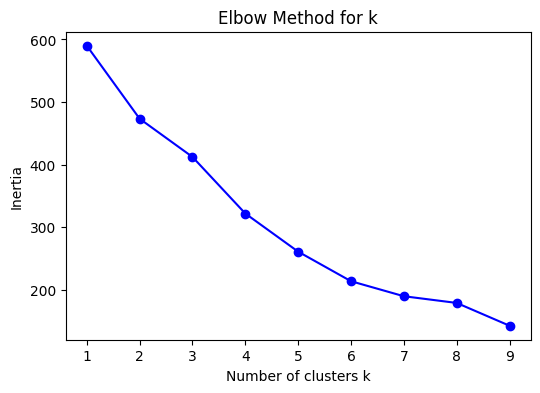

[-116.77562282  -61.10980059  -90.46465074  -61.01564907  -47.26767661
  -24.01651353  -10.72261682  -36.44844505]
[ 55.66582224 -29.35485015  29.44900167  13.74797246  23.25116308
  13.2938967  -25.72582823]


In [21]:
#clustering analysis 
features = ['IAY_PA', 'YAC_Cmp', 'IntPerAtt', 'DropPct', 'BadPct']
X = combined[features]
scaler = StandardScaler()
X = combined[features].dropna()
X_scaled = StandardScaler().fit_transform(X)
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method for k')
plt.show()

inertia = np.array(inertia)
first_derivative = np.diff(inertia)  # inertia[i+1] - inertia[i]
print(first_derivative)
second_derivative = np.diff(first_derivative)  # difference of slopes
print(second_derivative)

In [23]:
candidate_ks = [2, 4]

# Cleaned subset (drop rows with NaNs in the features)
combined_clean = combined[features].dropna()
X_scaled = StandardScaler().fit_transform(combined_clean)

for k in candidate_ks:
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    # Assign cluster labels only to the cleaned subset
    combined_clean[f'cluster_{k}'] = kmeans.labels_
    
    # Optional: Inspect cluster centers
    centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
    print(f"Cluster centers for k={k}:\n", centers, "\n")
    
    # Optional: Inspect cluster sizes
    cluster_sizes = combined_clean[f'cluster_{k}'].value_counts()
    print(f"Cluster sizes for k={k}:\n", cluster_sizes, "\n")


Cluster centers for k=2:
     IAY_PA   YAC_Cmp  IntPerAtt   DropPct    BadPct
0  0.07384  0.329237  -0.700576 -0.898353 -1.274923
1 -0.02406 -0.107279   0.228277  0.292722  0.415424 

Cluster sizes for k=2:
 cluster_2
1    89
0    29
Name: count, dtype: int64 

Cluster centers for k=4:
      IAY_PA   YAC_Cmp  IntPerAtt   DropPct    BadPct
0 -0.229634 -0.282250  -0.454089 -0.491802 -0.679710
1  0.006171 -0.095051   0.371408  0.436352  0.613693
2  7.535115 -1.375046  -0.741720 -1.184080 -1.755084
3  0.476984  4.088936  -0.741720 -1.184080 -1.755084 

Cluster sizes for k=4:
 cluster_4
1    67
0    45
3     5
2     1
Name: count, dtype: int64 



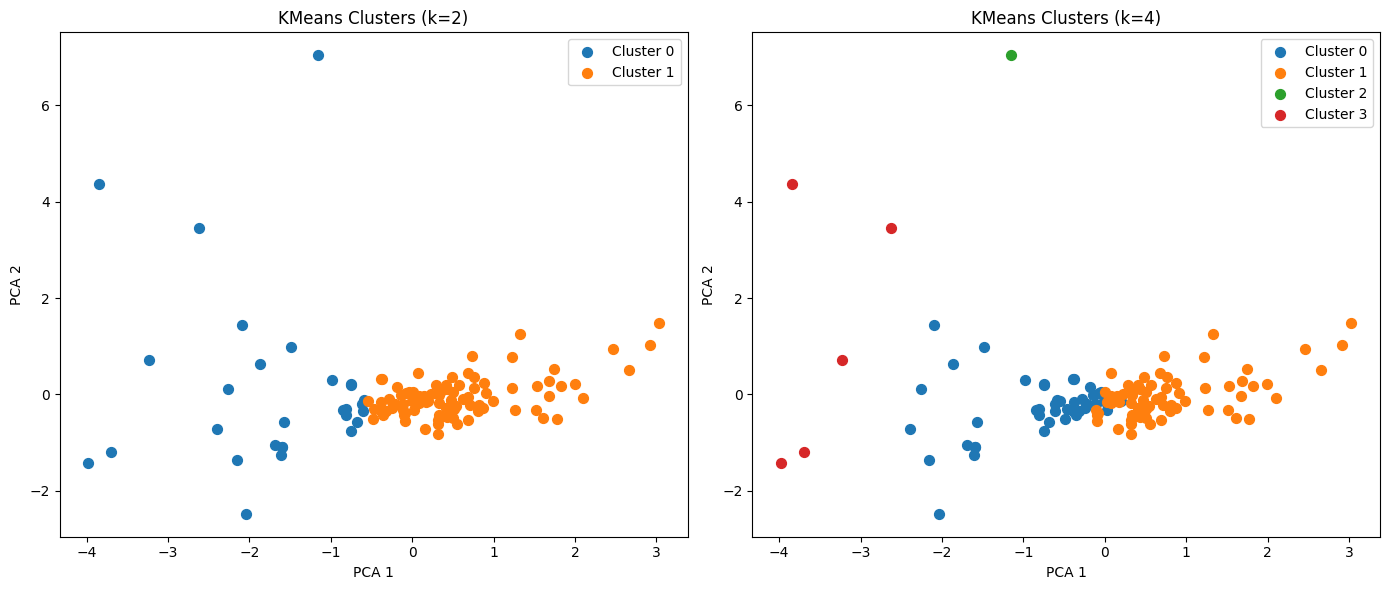

In [26]:
# Clean the data
combined_clean = combined[features].dropna()
X_scaled = StandardScaler().fit_transform(combined_clean[features])

# Candidate ks
candidate_ks = [2, 4]

# Prepare PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, k in enumerate(candidate_ks):
    # Fit KMeans
    clusters = KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)
    combined_clean[f'cluster_{k}'] = clusters
    
    # Plot
    ax = axes[i]
    for cluster in range(k):
        subset = X_pca[clusters == cluster]
        ax.scatter(subset[:, 0], subset[:, 1], label=f'Cluster {cluster}', s=50)
    
    ax.set_title(f'KMeans Clusters (k={k})')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.legend()

plt.tight_layout()
plt.show()

In [27]:
loadings = pd.DataFrame(pca.components_, columns=features, index=['PCA1', 'PCA2'])
print(loadings)

        IAY_PA   YAC_Cmp  IntPerAtt   DropPct    BadPct
PCA1  0.051977 -0.357390   0.484713  0.503051  0.617709
PCA2  0.954558  0.162062   0.200668 -0.147342 -0.024026


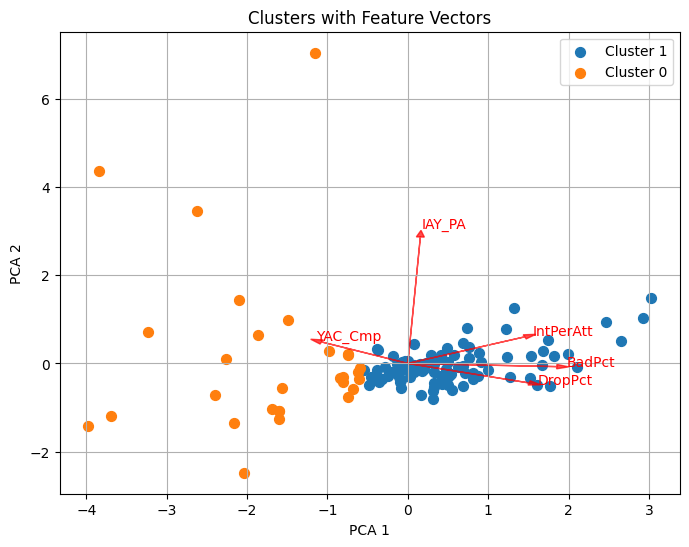

In [28]:
plt.figure(figsize=(8,6))

# Plot the clusters
for cluster in combined_clean['cluster_2'].unique():
    subset = X_pca[combined_clean['cluster_2']==cluster]
    plt.scatter(subset[:, 0], subset[:, 1], label=f'Cluster {cluster}', s=50)

# Plot feature vectors
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings.loc['PCA1', feature]*3, loadings.loc['PCA2', feature]*3, 
              color='r', alpha=0.7, head_width=0.1)
    plt.text(loadings.loc['PCA1', feature]*3.2, loadings.loc['PCA2', feature]*3.2, feature, color='r')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters with Feature Vectors')
plt.legend()
plt.grid(True)
plt.show()